In [1]:
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import hidden
import json
import numpy as np
import re
from datetime import datetime
import pytz
import re
from operator import itemgetter
import trade_models

In [2]:
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [3]:
VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]

config_keys = ['simulation_id', 'strategy_name', 'model', 'pair_id', 'start_time', 'max_batch_size', 'extra_rows', 'starting_funds', 'trading_fees_percent', 'trading_fees_buy', 'trading_fees_sell']

In [4]:
def get_state(config):
    sql = f"""
    select * from simulation_record where open_time = (select max(open_time) from simulation_record sr where simulation_id = {config['simulation_id']}) and simulation_id = {config['simulation_id']}
    """
    latest_record = pd.read_sql_query(sql, conn)
    if len(latest_record) > 0:
        return (
            latest_record['open_time'][0] + pd.to_timedelta(1,'s'),
            latest_record['fund1'][0],
            latest_record['fund2'][0]
        )
    else:
        return (config['start_time'], config['starting_funds'], 0)

In [5]:
def get_batch_data(pair_id, start_time, columns, batch_size=10000, extra_rows=0):
    column_info = [(x,) + re.match('^(?P<feature>[a-z][a-z0-9]*(?:_[a-z][a-z0-9]*)*)(?:_(?P<shift>[0-9]{1,3}))?$',x).groups() for x in columns]
    max_lookback = max([(0 if x==None else int(x)) for _,_,x in column_info])
    sql = f"""
select
    f.*, open_time, open, high, low, close, volume, close_time, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume	
from
    (
        (select * from candlestick_15m where pair_id = {pair_id} and close_time notnull and open_time < '{start_time}' order by open_time desc limit {max_lookback + extra_rows})
            union all
        (select * from candlestick_15m where pair_id = {pair_id} and close_time notnull and open_time > '{start_time}' order by open_time limit {batch_size})
    ) cm
inner join 
    features f on f.pair_id = cm.pair_id and f.candle_open_time = cm.open_time
order by
    open_time desc
"""
    base_df = pd.read_sql_query(sql, conn)
    df = base_df[['candle_open_time']].copy()
    for name, feature, shift in column_info:
        assert feature in VALID_FEATURES, f"Invalid feature: {feature} for {name}"
        df[name] = base_df[feature].shift((0 if shift==None else -int(shift)))
        
    if extra_rows == 0:
        extra_df = None
    else:
        extra_df = df.copy()
        extra_df['is_extra'] = ~(extra_df['candle_open_time'] >= start_time)
        extra_df = extra_df.set_index('candle_open_time').sort_index()
        
    df = df[df['candle_open_time'] >= start_time]
    df = df.set_index('candle_open_time').sort_index()

    ref_df = base_df[['open_time','open', 'high', 'low', 'close']].copy()
    ref_df = ref_df[ref_df['open_time'] >= start_time]
    ref_df = ref_df.set_index('open_time').sort_index()

    batch_close_time = base_df['close_time'].max()

    return df, ref_df, extra_df, batch_close_time

In [6]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()

In [7]:
sim_id=2

sql = f"""select si.id as simulation_id, st.strategy_name, st.model, st.max_batch_size, st.extra_rows, st.parameters, si.info_dict, e.starting_funds, e.trading_fees_percent, e.trading_fees_buy, e.trading_fees_sell, e.pair_id, to_char(e.starting_timestamp :: date, 'yyyy-mm-dd') as start_time from simulation si inner join strategy st on si.strategy_id = st.id inner join environment e on si.environment_id = e.id where si.id = {sim_id}"""
simulation_info = pd.read_sql_query(sql, conn).iloc[0]

config = {}
for k in config_keys:
    config[k] = simulation_info[k]
config = {**config, **simulation_info['parameters']}
config = {**config, **simulation_info['info_dict']}

# validate inputs and portfolio parameters
def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(config['start_time'])

# validate starting funds
assert config['starting_funds'] > 0, "Starting funds for must be > 0"

# validate fees
assert config['trading_fees_percent'] >= 0, "Trading Fees % for must be >= 0%"
assert config['trading_fees_percent'] < 100, "Trading Fees % for must be < 100%"
assert config['trading_fees_buy'] >= 0, "Trading Fees (buy) for must be >= 0"
assert config['trading_fees_sell'] >= 0, "Trading Fees (sell) for must be >= 0"

# validate batch size
assert config['max_batch_size'] > 0, f"{config['max_batch_size']} is not a valid batch size"

t,f1,f2 = get_state(config)
cur_funds = [f1,f2]
current_batch_start_time = t


fee_multiplier = 1.0 - config['trading_fees_percent'] / 100


model = trade_models.__dict__[config['model']]
columns = model.columns(config)

print("Current batch: ", current_batch_start_time)

batch_data, results, extra_data, batch_close_time = get_batch_data(config['pair_id'], current_batch_start_time, columns, config['max_batch_size'], config['extra_rows'])

# Replace any boolean or object columns as int
for col in batch_data.columns:
    if batch_data[col].dtype.kind in ['b','O']:
        batch_data[col] = batch_data[col].astype(int)

batch_model_decision, batch_execute_price = model.make_decision(batch_data[columns], extra_data, config)

results['trade_model_decision'] = batch_model_decision.values
results['execute_price'] = batch_execute_price.values

results[['actual_action','fund1','fund2']] = np.nan
results.iloc[0, results.columns.get_loc('fund1')] = cur_funds[0]
results.iloc[0, results.columns.get_loc('fund2')] = cur_funds[1]

print("...Simulating actions...")

for x,r in results.iterrows():
    if cur_funds[0] > 0 and cur_funds[1] == 0:
        if r['trade_model_decision'] > 0:
            cur_funds[1] = ((cur_funds[0]-config['trading_fees_buy']) * r['execute_price']) * fee_multiplier
            cur_funds[0] = 0
            results.loc[x,'fund1'] = cur_funds[0]
            results.loc[x,'fund2'] = cur_funds[1]
            results.loc[x,'actual_action'] = 'buy'
    elif cur_funds[1] > 0 and cur_funds[0] == 0:
        if r['trade_model_decision'] < 0:
            cur_funds[0] = ((cur_funds[1]-config['trading_fees_sell']) / r['execute_price']) * fee_multiplier
            cur_funds[1] = 0
            results.loc[x,'fund1'] = cur_funds[0]
            results.loc[x,'fund2'] = cur_funds[1]
            results.loc[x,'actual_action'] = 'sell'
    else:
        # you have run out of money!
        pass
    
results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
results['total_value'] = results['fund1'] + results['fund2'] / results['close']
results['actual_action'] = results['actual_action'].fillna('none')
records = results.reset_index()[['open_time', 'execute_price', 'actual_action', 'fund1', 'fund2', 'total_value']]
records = records.rename(columns={'actual_action':'trade_action'})
records['simulation_id'] = sim_id
execute_values(conn, records, 'simulation_record')

cursor = conn.cursor()
info_dict = {k:v for k,v in config.items() if k not in config_keys}
cursor.execute(f"update simulation set info_dict='{json.dumps(info_dict)}' where id={config['simulation_id']}")
conn.commit()
cursor.close()

Current batch:  2021-04-04 20:45:01
...Simulating actions...
execute_values() done


<AxesSubplot:title={'center':"Tim's Dummy"}, xlabel='open_time'>

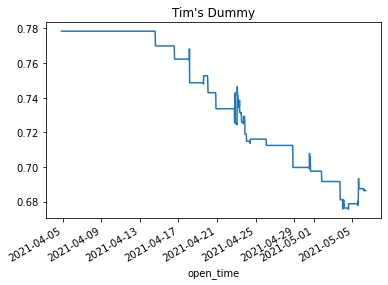

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_title(config['strategy_name'])
results.total_value.plot(figure=fig)

In [9]:
# Daily value
results[results.index.hour + results.index.minute == 0]['total_value']

open_time
2021-04-05    0.778328
2021-04-06    0.778328
2021-04-07    0.778328
2021-04-08    0.778328
2021-04-09    0.778328
2021-04-10    0.778328
2021-04-11    0.778328
2021-04-12    0.778328
2021-04-13    0.778328
2021-04-14    0.778328
2021-04-15    0.769795
2021-04-16    0.769795
2021-04-17    0.762211
2021-04-18    0.762211
2021-04-19    0.748574
2021-04-20    0.752588
2021-04-21    0.733567
2021-04-22    0.733567
2021-04-23    0.724950
2021-04-24    0.718957
2021-04-25    0.716034
2021-04-26    0.716034
2021-04-27    0.712400
2021-04-28    0.712400
2021-04-29    0.699688
2021-04-30    0.699688
2021-05-01    0.697545
2021-05-02    0.691559
2021-05-03    0.691559
2021-05-04    0.680360
2021-05-05    0.678744
2021-05-06    0.687457
Name: total_value, dtype: float64